In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip /content/gdrive/MyDrive/archive.zip

In [3]:
import librosa
import librosa.display 

In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import matplotlib.pyplot as plt , numpy as np , os , json

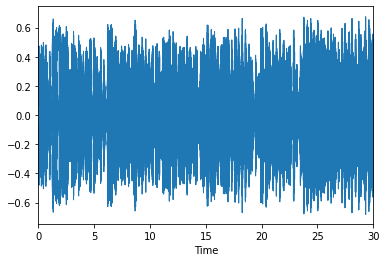

In [7]:
song , sr = librosa.load('/content/Data/genres_original/jazz/jazz.00054.wav')
librosa.display.waveplot(song)

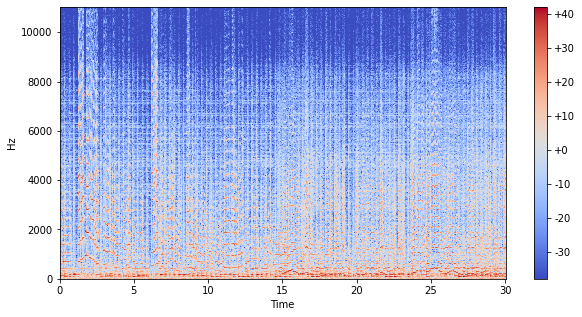

In [8]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(Y, sr=sr, hop_length=1024, x_axis="time", y_axis=y_axis)
    plt.colorbar(format="%+2.f")
Y_log = librosa.power_to_db(np.abs(librosa.stft(song, hop_length=1024))**2)
plot_spectrogram(Y_log, sr, 1024)

<class 'numpy.ndarray'>


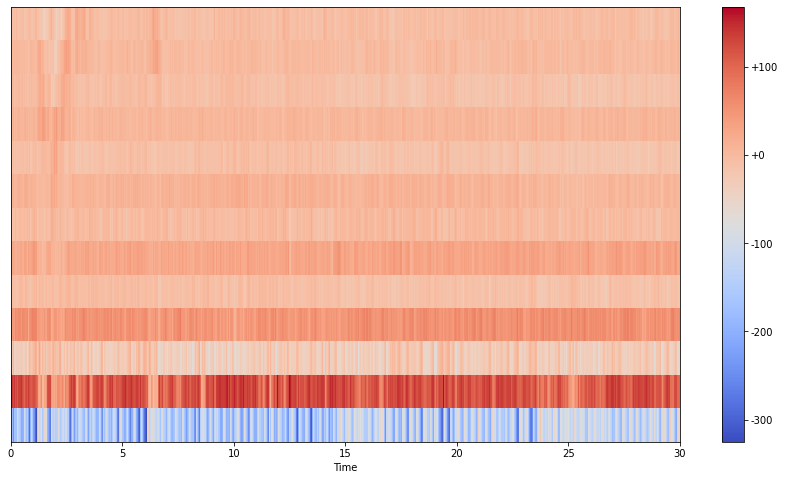

In [9]:
mfcc_song = librosa.feature.mfcc(song, n_mfcc=13, sr=sr)
print(type(mfcc_song) )
plt.figure(figsize=(15, 8))
librosa.display.specshow(mfcc_song, x_axis="time", sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [10]:
SOURCE_PATH = '/content/Data/genres_original/'


JSON_PATH = 'data.json'
#sampling rate
sr = 22050

TOTAL_SAMPLES = 29 * sr 

NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [11]:

def preprocess_data(source_path):
    
    mydict = {
        "labels" : [] ,
         "mfcc" : []  
          }
    
    music = ['reggae', 'jazz', 'country', 'hiphop', 'rock', 'metal', 'classical', 'disco', 'blues', 'pop']
    
    path = 'Data/genres_original/'
    i = 0 


    for n in music : 
       new_path = path + n
       song = os.listdir(new_path)
       for p in song:
            if p != ".ipynb_checkpoints" :
                final_path = new_path + "/" + p
            #here we first walk through all the files and generate a 13 band mfcc for each sample and append it in the dict 
                melody , sr = librosa.load(final_path , duration=29)
            #creating 10 samples for each file
                for s in range(NUM_SLICES): 
                   start_sample = SAMPLES_PER_SLICE * s
                   end_sample = start_sample + SAMPLES_PER_SLICE
                   print("start: " , start_sample , ", end: " , end_sample )
                   mfcc = librosa.feature.mfcc(melody[start_sample : end_sample], sr=sr, n_mfcc=13)
                   mfcc = mfcc.T
                   print(mfcc.shape)
                   mydict["labels"].append(i)
                   mydict["mfcc"].append(mfcc.tolist()) 
       print(i)
       i+= 1 
    with open("data.json", 'w') as f:
        json.dump(mydict, f)
    f.close()
    


In [12]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    print(X.shape)

    return X, y

In [ ]:
preprocess_data("Data/genres_original")

In [14]:
with open("data.json", 'r') as f:
        data = json.load(f)
f.close()
x = np.array(data["mfcc"])
y = np.array(data["labels"])

In [15]:
x = x.reshape( x.shape[0] , x.shape[1] , x.shape[2] , 1)

In [88]:
train_data_in ,test_data_in , train_data_targets  ,  test_data_targets = train_test_split(x , y , test_size = 0.1 )
inputs_train, inputs_test, targets_train, targets_test = train_test_split(train_data_in , train_data_targets, test_size=0.1)

In [100]:
def design_model(input_shape):

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        
        
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    return model

In [102]:
shape_ = (125 , 13 , 1)
model1 = design_model(shape_)
model1.summary()
model1.compile(
       optimizer = 'adam' ,
       loss = 'sparse_categorical_crossentropy' ,
       metrics = 'accuracy'
)

model_history = model1.fit(
                        inputs_train, targets_train,
                        validation_data=(inputs_test, targets_test),
                        epochs=40,
                        batch_size=64
                        )



Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 62, 6, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_88 (Conv2D)          (None, 60, 4, 64)         18496     
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 30, 2, 64)        0         
 g2D)                                                            
                                                                 
 dropout_58 (Dropout)        (None, 30, 2, 64)         0         
                                                                 
 conv2d_89 (Conv2D)          (None, 29, 1, 128)      

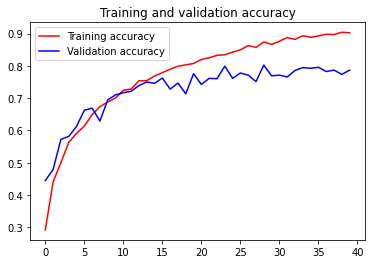

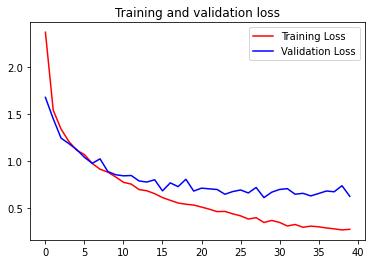

In [103]:
model_history.history
def plot_performance(hist):
    
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()  

    plt.show()

plot_performance(model_history)

In [104]:
def get_mfcc(path):
  song , sr = librosa.load(path , duration = 29)
  librosa.display.waveplot(song)
  mfcc_song = librosa.feature.mfcc(song[ 383670 :  447615], n_mfcc=13, sr=sr)
  mfcc_song = mfcc_song.T 
  mfcc_song = np.array(mfcc_song)
  
  return mfcc_song 


(1, 125, 13, 1)


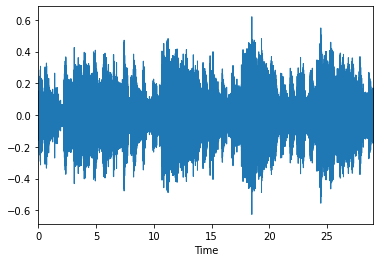

In [105]:
X = get_mfcc("/content/Data/genres_original/jazz/jazz.00055.wav")
X = X.reshape( 1 , 125  , 13 ,1 )
print(X.shape)

In [113]:
predict = model1.predict(test_data_in)

32/32 [==============================] - 0s 2ms/step


In [116]:
acc = 0 
for i in range(len(predict)):
  print(i + 1 , "predicted: " , np.argmax(predict[i]) , "actual: " , test_data_targets[i] )
  if np.argmax(predict[i]) == test_data_targets[i]:
    acc += 1 
print("accuracy : " , acc/1000* 100 , "%" )

1 predicted:  0 actual:  0
2 predicted:  9 actual:  9
3 predicted:  5 actual:  5
4 predicted:  3 actual:  4
5 predicted:  3 actual:  3
6 predicted:  5 actual:  5
7 predicted:  5 actual:  5
8 predicted:  1 actual:  6
9 predicted:  9 actual:  0
10 predicted:  3 actual:  3
11 predicted:  8 actual:  8
12 predicted:  4 actual:  3
13 predicted:  0 actual:  0
14 predicted:  8 actual:  8
15 predicted:  9 actual:  9
16 predicted:  0 actual:  3
17 predicted:  7 actual:  4
18 predicted:  3 actual:  0
19 predicted:  9 actual:  7
20 predicted:  9 actual:  3
21 predicted:  4 actual:  4
22 predicted:  8 actual:  3
23 predicted:  4 actual:  4
24 predicted:  6 actual:  6
25 predicted:  8 actual:  2
26 predicted:  0 actual:  7
27 predicted:  1 actual:  1
28 predicted:  5 actual:  5
29 predicted:  3 actual:  3
30 predicted:  7 actual:  0
31 predicted:  9 actual:  9
32 predicted:  0 actual:  0
33 predicted:  7 actual:  8
34 predicted:  8 actual:  8
35 predicted:  0 actual:  0
36 predicted:  1 actual:  1
3